## Importación de bibliotecas 

In [4]:
# Entorno de ejecución

# if (firstrun):
if('google.colab' in str(get_ipython() ) ):
    environment= 'google'
else:
    import os
    if (os.environ.get('PWD')=='/kaggle/working'):
        environment= 'kaggle'
    else:
        environment= 'local'
print(environment)

local


In [231]:
# ! pip install pyclustering
# ! pip install cv2
# ! pip install tensorflow
# !pip install scikit-learn-extra

ERROR: Could not find a version that satisfies the requirement sklearn_extra (from versions: none)
ERROR: No matching distribution found for sklearn_extra


In [321]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Modelos
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.utils  import load_img
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors # Para aplicar KNN y buscar el "eps" en DBSCAN
from kneed import KneeLocator # Para encontrar el codo en la curva y definir el "eps" óptimo en DBSCAN
from sklearn_extra.cluster import KMedoids

from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.silhouette import silhouette
from pyclustering.cluster.elbow import elbow
from sklearn.preprocessing import MinMaxScaler
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer


# Métricas
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

# Warnings
import warnings

# Suprime todas las advertencias FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Funciones de utilidad

In [7]:
def van_Dongen_index(labels_original, labels_pred):
    a = sum(1 for i in range(len(labels_original)) for j in range(i + 1, len(labels_original))
            if labels_original[i] == labels_original[j] and  labels_pred[i] ==  labels_pred[j])

    b = sum(1 for i in range(len(labels_original)) for j in range(i + 1, len(labels_original))
            if labels_original[i] != labels_original[j] and  labels_pred[i] == labels_pred[j])

    c = sum(1 for i in range(len(labels_original)) for j in range(i + 1, len(labels_original))
            if labels_original[i] == labels_original[j] and labels_pred[i] != labels_pred[j])

    d = sum(1 for i in range(len(labels_original)) for j in range(i + 1, len(labels_original))
            if labels_original[i] != labels_original[j] and labels_pred[i] != labels_pred[j])

    van_Dongen_index = (b + c) / (a + b + c + d)
    return van_Dongen_index

def obtengo_labels_originales(names):
    # Obtenemos los labels originales a partir del arreglo names
    labels_original = []

    for path in names:
        # Dividir la ruta por la barra invertida ('\')
        partes = path.split('\\')
        # Obtener la última parte que contiene el nombre del archivo (ejemplo: 'Arborio (1002).jpg')
        nombre_archivo = partes[-1]
        # Dividir el nombre del archivo por el paréntesis '('
        partes_nombre = nombre_archivo.split('(')
        # Obtener el tipo de arroz eliminando el último carácter (')') y agregándolo al nuevo arreglo
        tipo_arroz = partes_nombre[0].strip()
        labels_original.append(tipo_arroz)
    return labels_original

def validacion_externa(names, modelo):
    labels_original = obtengo_labels_originales(names)
    # Armamos la matríz de confusión para el modelo indicado
    df = pd.DataFrame({'Labels_orig': labels_original, 'Labels_clust': modelo.labels_})
    cross_table = pd.crosstab(df['Labels_clust'],df['Labels_orig'])
    
    # Calculamos el índice de Rand Ajustado
    ari = adjusted_rand_score(labels_original, modelo.labels_)
    print("Índice de Rand Ajustado:", ari)
    
    # Calculamos el índice de Van Dogen
    vanDogen = van_Dongen_index(labels_original,  modelo.labels_)
    print("Índice de van Dongen:", vanDogen)
    
    return cross_table

def save_cluster_examples(cluster_label, modelo, names, num_examples=10,):
    path_predict = pd.DataFrame(zip(names, modelo.labels_))
    cluster_indices = np.where(path_predict[1] == cluster_label)[0]
    selected_indices = np.random.choice(cluster_indices, size=min(num_examples, len(cluster_indices)), replace=False)
    labels_original = obtengo_labels_originales(names)
    labels_modelo = modelo.labels_
    plt.figure(figsize=(12, 4))

    for i, idx in enumerate(selected_indices):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(np.array(load_img(path_predict[0][idx])))
        plt.title(f"Clt {labels_modelo[idx]} , {labels_original[idx]}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    

## Carga de datos

Si trabajan local
**ESCRIBIR EN SYSTEM PATH EL QUE CORRESPONDA A SUS COMPUTADORAS**

Si trabajan en colab
**ESCRIBIR EN SYSTEM PATH EL QUE CORRESPONDA A SU DRIVE**

In [8]:
# Directorio base ( cambiar según el sistema de archivos de cada uno)
# if (firstrun):

if( environment== 'local' ):
    system_path = "C:/Users/vanes/Documents/UBA/2do_cuatrimestre/DMCyT/TP/"
    # system_path = '/home/vbettachini/documents/universitet/FCEyN/maestríaDatos/cienciaTecnología/'
elif( ( environment== 'google' ) ): 
    from google.colab import drive
    drive.mount('/content/drive')
    system_path = "/content/drive/MyDrive/maestría/cienciaTecnología/"
elif( ( environment== 'kaggle' ) )  :
    a= 1

# Directorio del dataset
dataset_path = r"C:\Users\tgian\dmcyt2023\datasets\Rice_Image_Dataset"

In [9]:
# Path a subset imágenes generado por `random_sample_rice_images.ipynb`
image_path = dataset_path + r"\ramdon_sample_rice_image"

In [10]:
# Cargamos datos 
data = np.load(image_path + '/vgg16output.npz')
data.files

['feat', 'names']

In [11]:
# Asigno a la variable feat las características obtenidas del modelo VGG y a la variable names el path de todas las imagenes
names = data['names']
feat = data['feat']

# Cantidad de registros / observaciones
print("Cantidad de registros:", len(feat))
      
# Cantidad de paths
print("Cantidad de registros:", len(names))

# Cantidad de features por observación
print("Cantidad de registros:", len(feat[0]))

# Verifico al menos un path
print(names[0])
      
    

Cantidad de registros: 5000
Cantidad de registros: 5000
Cantidad de registros: 4096
C:\Users\tgian\dmcyt2023\datasets\Rice_Image_Dataset\ramdon_sample_rice_image\Arborio (10003).jpg


## 6.a K-means

Consigna: Aplicar KMeans sobre el conjuntos de datos (con distintas métricas, normalizaciones,
combinaciones, etc). Determinar la cantidad de clusters utilizando silhuette y SSE.

Aplicaremos un modelo de aprendizaje automático no supervisado llamado Kmeans que nos permitirá agrupar lar imagenes en clusters dependiendo de las características visuales de cada una. Tomaremos la salida del modelo VGG16 mencionado anteriormente (apartado anterior) la cual tiene una estructura de 5000 observaciones y 4096 características.

### **Normalización de los datos**:

Lo primero que realizaremos es verificar si realmente los datos están normalizados entre 0 y 1. En caso contrario, se aplicará un escalador de mímino y máximo para estandarizar los datos.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [12]:
# Asigno a la variable x las características
x = feat

In [13]:
# # Verifico que todos los elementos del arreglo x de características esté normalizado entre 0 y 1:
# if array_normalized(x):
#     print("Todos los elementos están normalizados entre 0 y 1.")
# else:
#     print("Al menos un elemento no está normalizado entre 0 y 1.")

In [14]:
# Normalizo el arreglo entre 0 y 1
# Creo una instancia de MinMaxScaler
scaler = MinMaxScaler()

# AJusto el scaler a los datos
x_nor = scaler.fit_transform(x)

### **Modelo**: 
Implementaremos el modelo Kmeans variando la cantidad de clusters y con el objetivo de encontrar cantidad de clusters óptimo. 

Para esto utilizaremos 2 librerías sklearn y pyclustering.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

https://pyclustering.github.io/docs/0.8.2/html/da/d22/classpyclustering_1_1cluster_1_1kmeans_1_1kmeans.html

#### **Validación interna**: 

Utilizaremos las siguientes medidas para evaluar la calidad de los clusters obtenidos en cada implementación. Estas  nos permitirán medir la coherencia y la separación de los mismos. 

SSE: Mide la dispersión de las observaciones dentro de cada cluster, cuanto menor sea el SSE, más compactos y coherentes serán los clusters. 

Silhouette Score: Mide cuán similar es cada punto de datos a su propio cluster comparándolo con otros clusters cercanos. Este score varía entre -1 y 1 y mientras más cerano a 1 indicará que el punto está bien agrupado, cuanto más cercano a cero o negativo sea, indicará que está en el cluster incorrecto.


### Kmeans con Sklearn

In [254]:
# Veamos para una serie de valores de n_clusters cómo se comportan las métricas expuestas:
# Guardaremos cada modelo entrenado en una lista de modelos
k_range = [i for i in range(2,20)]
sse_list = []
silhouette_list = []
modelos = []

for i in k_range:
    # Aplico el modelo
    kmeans = KMeans(n_clusters=i,  random_state = 8)
    kmeans.fit(x_nor)
    
    # Guardo el modelo 
    modelos.append(kmeans)
    
    # Evaluo métricas
    # SSE:
    labels = kmeans.predict(x_nor)
    centroides = kmeans.cluster_centers_
    sse = 0  
    for i in range(len(x_nor)):
        cluster_center = centroides[labels[i]]
        sse += np.sum((x_nor[i] - cluster_center) ** 2)
    # Guardo score
    sse_list.append(sse)
    
    # Silhouette Score
    silhouette_avg = silhouette_score(x_nor, labels)
    # Guardo score
    silhouette_list.append(silhouette_avg)

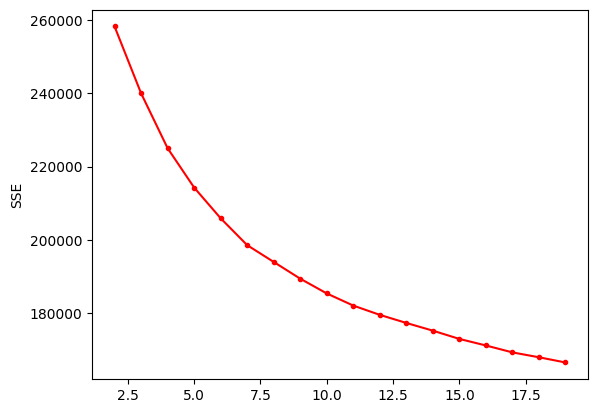

In [16]:
# Graficamos los resultados obtenidos para cada métrica
# SSE
plt.plot(k_range,sse_list,'r.-')
plt.ylabel('SSE')
plt.show()

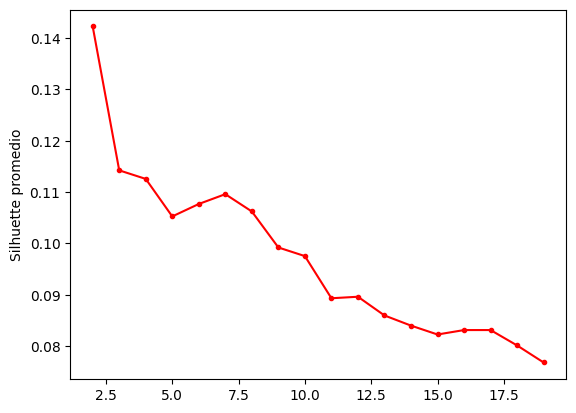

In [17]:
# Silhouette Score
plt.plot(k_range,silhouette_list,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

**Conclusiones**:

- Del gráfico del SSE podemos notar que el valor de la métrica disminuye mientras aumenta la cantidad de clusters de una forma suave, sin presentar un quiebre que indique de forma obvia la cantidad de clusters óptimo. Esto quizas se deba a que nuestros datos no poseen una estructura de clusters clara.

- Del gráfico del Score de Silhouette podemos notar que para todos los valores de n_clusters seleccionados el valor de silhouette es cercano a cero por lo que no podríamos tomar con certeza una cantidad válida de clusters.

Sin embargo, mostraremos visualmente cómo agrupa las imagenes tomando 5 clusters (labels originales) y 7 clusters.

### Validación externa:

Evaluaremos para los n_clusters seleccionados cómo varía respecto a las etiques originales de las imagenes, para esto, utilizaremos las siguientes técnicas de validación:

- Matríz de Confusión

- Índice de Rand ajustado : puede proporcionar un valor entre -1 y 1, donde 1 indica una concordancia perfecta entre las asignaciones de clústeres y 0 indica una asignación aleatoria. Un valor negativo indica una asignación menos acertada que una asignación aleatoria.

- Índice de VanDogen : Es una métrica de disimilaridad entre particiones basada también en la intersección máxima de clusters. Vale cero cuando las particiones son iguales.

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.colibri.udelar.edu.uy/jspui/bitstream/20.500.12008/21101/1/tm-mgonzalez.pdf 


In [18]:
# Para n_clusters = 5
n_clusters = 5
modelo = modelos[3]
mc = validacion_externa(names, modelo)
mc

Índice de Rand Ajustado: 0.4350090201391971
Índice de van Dongen: 0.1825641928385677


Labels_orig,Arborio,Ipsala,Jasmine,Karacadag,basmati
Labels_clust,,,,,
0,379,429,296,39,6
1,93,4,0,948,0
2,0,0,78,0,605
3,519,557,26,13,1
4,9,10,600,0,388


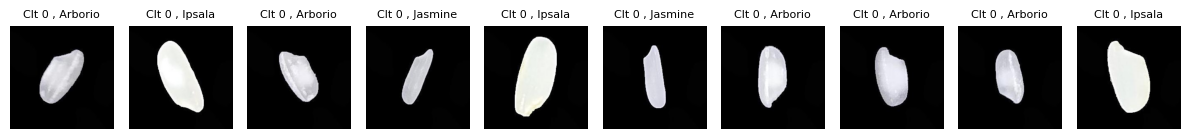

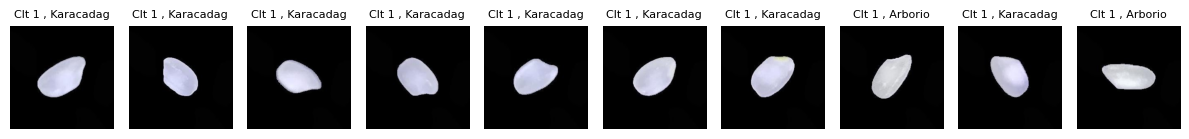

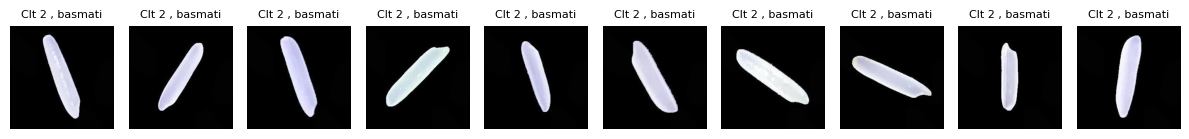

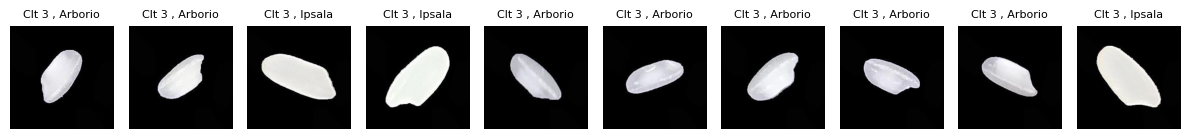

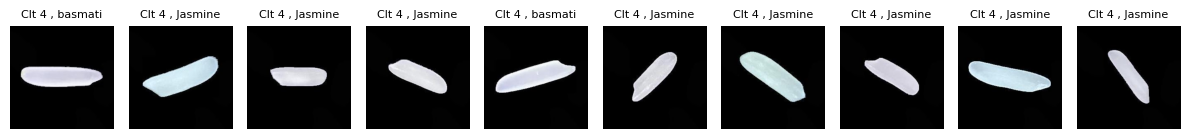

In [19]:
# Observación de etiquetas reales con predichas
for cluster_label in range(n_clusters):
    save_cluster_examples(cluster_label, modelo, names, num_examples=10)

**Conclusiones**:

- El índice de Rand Ajustado da 0.42 lo cual nos indica que no hay una coindencia exacta entre lo obtenido por el modelo y las etiquetas reales. Sin embargo, no es tan cercano a cero. 

- EL Índice de van Dongen por su parte nos da 0.18, lo cual también indica que hay cierta certezada en los clusters obtenido respecto a lo real. 

- La matríz de confusión y la figura evidencian que al menos el tipo de arroz Karacadag lo clasifica bastante bien el clusters 2 y podemos observar que es un tipo de arroz bastante con bordes bastantes redondeados por lo que está característtica parece identificarla bastante bien. Los clusters 3 y 4 si bien presentan confusión entre los tipos de Bssmati y Jasmine, podemos notar que agrupo arroces con forma particularmente alargadas. Los clusters 0 y 1 confunden bastante entre los tipos Arborio e Ipsala que a simple vista parecen ser bastante similares.




In [20]:
# Para n_clusters = 7
n_clusters = 7
modelo = modelos[5]
mc = validacion_externa(names, modelo)
mc

Índice de Rand Ajustado: 0.49669966310228575
Índice de van Dongen: 0.14541852370474095


Labels_orig,Arborio,Ipsala,Jasmine,Karacadag,basmati
Labels_clust,,,,,
0,0,0,5,0,587
1,644,17,5,188,0
2,6,4,479,0,387
3,85,7,450,0,25
4,158,473,54,1,1
5,77,2,0,806,0
6,30,497,7,5,0


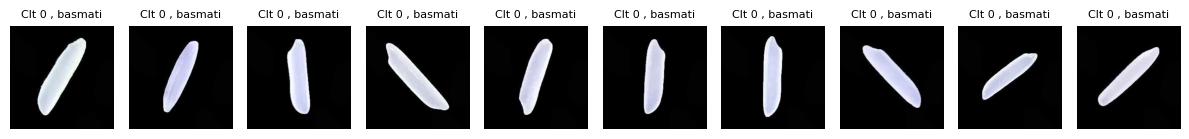

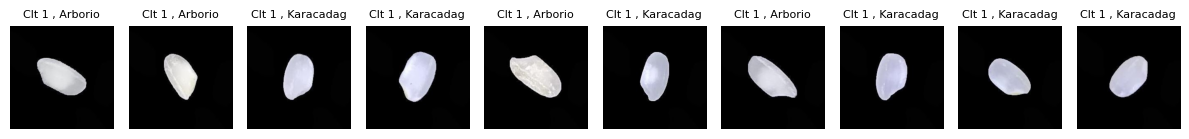

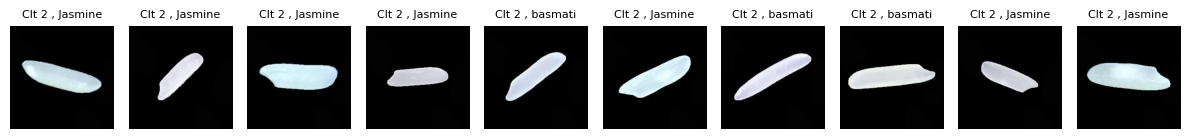

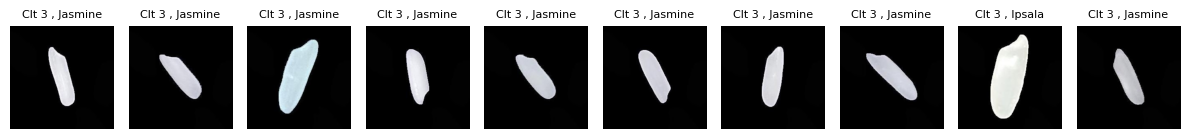

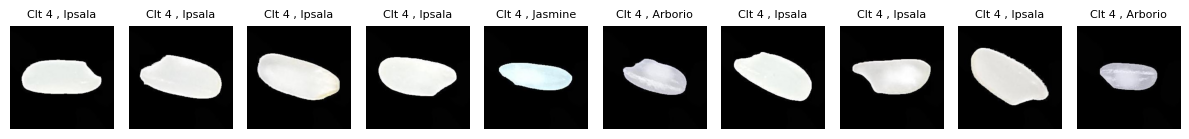

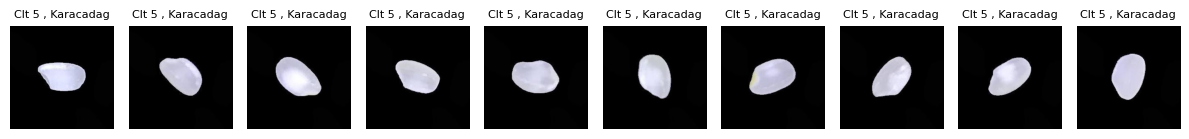

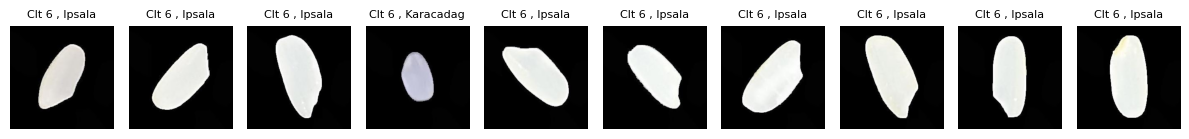

In [21]:
# Observación de etiquetas reales con predichas
for cluster_label in range(n_clusters):
    save_cluster_examples(cluster_label, modelo, names, num_examples=10)

**Conclusiones**:

- El índice de Rand Ajustado da 0.47 lo cual nos indica que no hay una coindencia exacta entre lo obtenido por el modelo y las etiquetas reales. Sin embargo, no es tan cercano a cero. 

- EL Índice de van Dongen por su parte nos da 0.15, lo cual también indica que hay cierta certezada en los clusters obtenido respecto a lo real. 

- Estos dos índices presentan una leve mejora respecto a la configuración de 5 clusters. 

- La matríz de confusión y la figura presentan mayor confusión en la mayoría de los clusters. Sin embargo, podemos destacar los clusters 0,1,4 y 7 que visualmente agrupa los arroces más alargados y más redondeados. 

### Kmeans con Pyclustering

Usaremos ahora pyclustering para ajustar el modelo kmeans con n_clusters fijo en 5 pero variando las métricas de distancia con las que calcula los clusters.

In [22]:
# distancias = [
#     type_metric.EUCLIDEAN,
#     type_metric.MANHATTAN,
#     type_metric.CHEBYSHEV,
#     type_metric.CANBERRA,
#     type_metric.CHI_SQUARE
# ]

# clusters_py = []
# list_silhouette = []

# sklearn_kmeans = modelos[3]
# centroides = sklearn_kmeans.cluster_centers_

# for distancia in distancias:
#     modelo = kmeans(x_nor, initial_centers=centroides, metric=distance_metric(distancia))
#     modelo.process()
#     clusters = modelo.get_clusters()
#     clusters_py.append(clusters)
#     sil = silhouette(x_nor, clusters).process().get_score()
#     avg_sil = np.mean(sil)
#     list_silhouette.append(avg_sil)

### PCA

Ahora aplicaremos la técnica de reducción de dimensionalidad PCA:

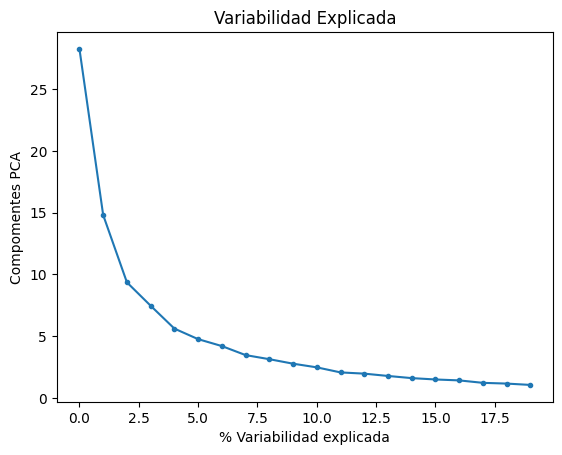

In [23]:
# Aplico PCA a las características obtenidas por el modelo VGG
pca = PCA(n_components=20)
x_pca = pca.fit_transform(x_nor)

# Observemos la variablidad explicada con las componentes elegidas
plt.plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
plt.title('Variabilidad Explicada')
plt.xlabel('% Variabilidad explicada')
plt.ylabel('Compomentes PCA')
plt.show()


In [24]:
100*pca.explained_variance_ / sum(pca.explained_variance_)

array([28.257404 , 14.803047 ,  9.355369 ,  7.4605784,  5.609677 ,
        4.755768 ,  4.1950455,  3.464319 ,  3.1327984,  2.7683446,
        2.4714336,  2.061888 ,  1.9623971,  1.7744957,  1.5997208,
        1.4896765,  1.4151081,  1.2170955,  1.1572273,  1.0486013],
      dtype=float32)

Notemos que podemos representar los datos con dos dimensiones PC1 y PC2 y explicando un 43% de la variabilidad total de los datos. Esto sugiere que la aplicación del PCA ha sido efectiva y nos permitirá visualizar clústeres con datos complejos en un espacio bidimensional.

In [25]:
# Aplicamos ahora Kmeans a los datos reducidos
kmeans = KMeans(n_clusters=5,  random_state = 8)
kmeans.fit(x_pca)

KMeans(n_clusters=5, random_state=8)

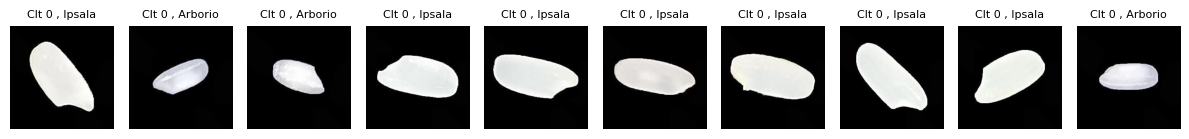

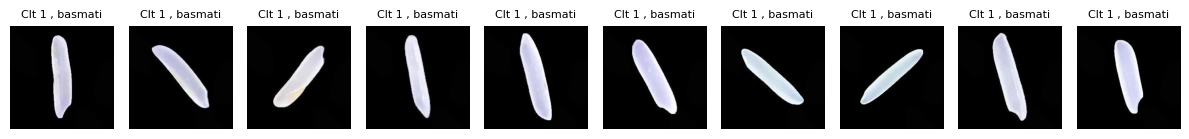

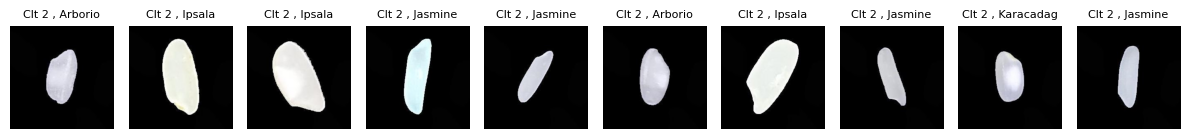

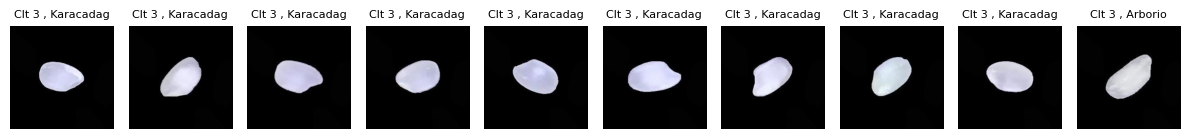

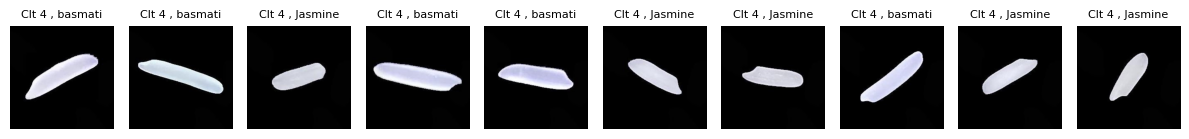

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [26]:
# Observo los clusters obtenidos
for cluster_label in range(n_clusters):
    save_cluster_examples(cluster_label, kmeans, names, num_examples=10)

In [27]:
# Para n_clusters = 5
n_clusters = 5
modelo = kmeans
mc = validacion_externa(names, modelo)
mc

Índice de Rand Ajustado: 0.43179311404074994
Índice de van Dongen: 0.1831114222844569


Labels_orig,Arborio,Ipsala,Jasmine,Karacadag,basmati
Labels_clust,,,,,
0,514,550,26,13,1
1,1,0,119,0,609
2,382,435,266,40,3
3,94,4,0,947,0
4,9,11,589,0,387


Se puede observar un descenso en el índice de Rand Ajustado el cual nos podría indicar que las nuevas asignaciones de clusters son menos similares usando 50 características respecto a las 4096 características que tomamos anteriormente. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


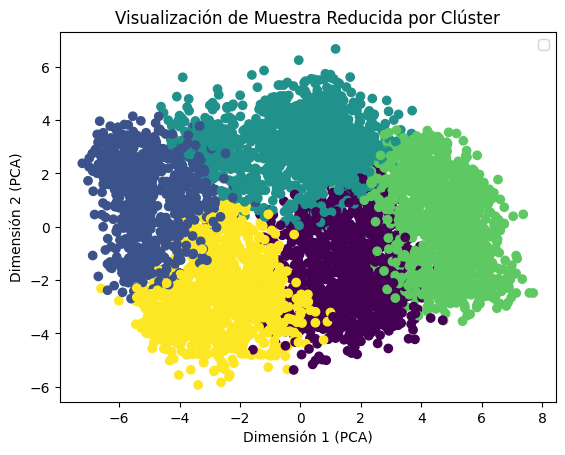

In [28]:
# Grafiquemos en un espacio bidimensional las PC1 y PC2
plt.scatter(x_pca[:, 0], x_pca[:, 1],c=kmeans.labels_)
    
# Agrega una leyenda al gráfico
plt.legend()

# Personaliza los títulos y etiquetas de los ejes
plt.title('Visualización de Muestra Reducida por Clúster')
plt.xlabel('Dimensión 1 (PCA)')
plt.ylabel('Dimensión 2 (PCA)')

# Muestra el gráfico
plt.show()

Este gráfico nos muestra como ha agrupado en 5 clusters el modelo. Se observan nubes de datos coherentes respecto a las etiquetas del modelo. Veamos ahora respecto a las etiquetas reales:

In [29]:
labels_original = obtengo_labels_originales(names)
categorias = list(set(labels_original))  # Obtiene las categorías únicas
mapeo_categorias = {categoria: numero for numero, categoria in enumerate(categorias)}

# Mapea las cadenas a números utilizando el diccionario
labels_num = [mapeo_categorias[categoria] for categoria in labels_original]


# Genero dataset con PC1, PC2 y el label_num
dataset = np.column_stack((x_pca[:, 0], x_pca[:, 1], labels_num))

df = pd.DataFrame(data=dataset, columns=['PC1', 'PC2', 'label_num'])

C:\Users\tgian\AppData\Local\Temp\ipykernel_22080\2585690877.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores_unicos = plt.cm.get_cmap('tab10', num_etiquetas)


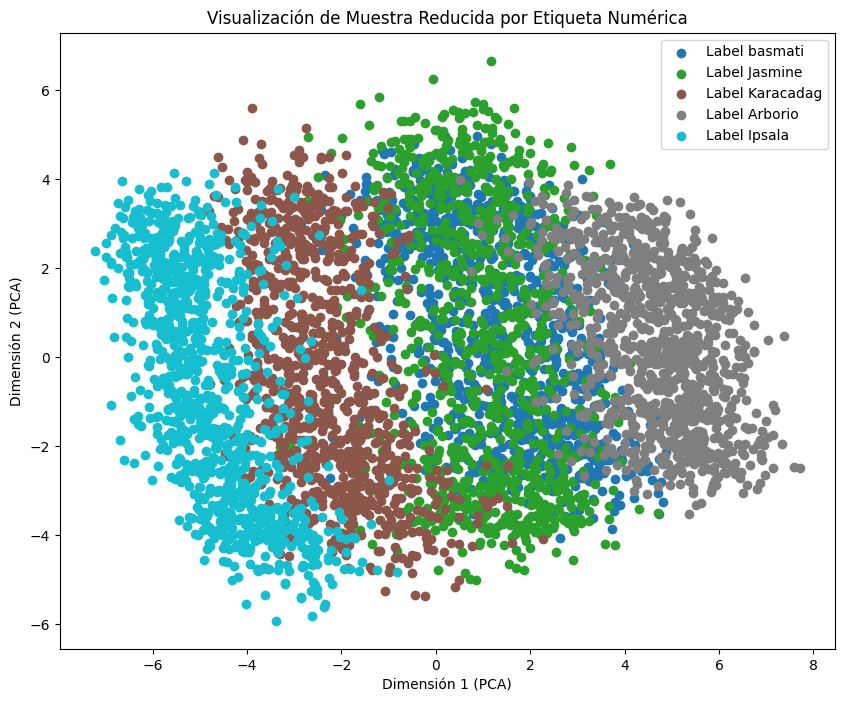

In [30]:
categorias_dic = {0: 'basmati', 1:'Jasmine', 2:'Karacadag', 3:'Ipsala', 4:'Arborio'}
plt.figure(figsize=(10, 8))

# Obtén el número de etiquetas únicas en 'label_num'
num_etiquetas = len(df['label_num'].unique())

# Genera colores únicos basados en el número de etiquetas
colores_unicos = plt.cm.get_cmap('tab10', num_etiquetas)

# Crear un diccionario para asignar colores únicos a cada etiqueta numérica
mapeo_colores = {etiqueta: colores_unicos(i) for i, etiqueta in enumerate(df['label_num'].unique())}

# Itera a través de las etiquetas únicas presentes en 'label_num'
for etiqueta in df['label_num'].unique():
    # Filtra los puntos de datos correspondientes a esta etiqueta
    x_pca_etiqueta = df[df['label_num'] == etiqueta]
    
    # Obtén el color único para esta etiqueta numérica
    color = mapeo_colores[etiqueta]
    
    # Grafica los puntos de datos de esta etiqueta con el color único
    plt.scatter(x_pca_etiqueta['PC1'], x_pca_etiqueta['PC2'], label=f'Label {categorias_dic[etiqueta]}', color=color)

# Personaliza los títulos y etiquetas de los ejes
plt.title('Visualización de Muestra Reducida por Etiqueta Numérica')
plt.xlabel('Dimensión 1 (PCA)')
plt.ylabel('Dimensión 2 (PCA)')

# Agrega una leyenda al gráfico
plt.legend()

# Muestra el gráfico
plt.show()

**Conclusiones**:

Es posible observar del gráfico en 2 dimensiones cómo el modelo logra agrupar bastante bien las observaciones del tipo de arroz Karacadag a la izquierda del gráfico, y presenta una mezcla bastante pronunciada en el medio entre los tipo Ipsala y Arborio, y a la derecha una mezcla parcial entre Jasmine y Basmati. Además, se corresponde con lo observado en la matriz de confusión.

## 6.b DBSCAN

Probaremos ahora el rendimiento de un método de clustering por densidad, como DBSCAN, para contrastar el desempeño con el de un algoritmo de partición como K-Means. <br>
DBSCAN se basa en dos hiperparámetros a definir por el usuario:
- eps: radio del entorno usado para definir los clusters.  
- MinPts: cantidad mínima de puntos, en el entorno de un punto dado, necesaria para que éste se considere una semilla (incluyendo al propio punto).

Para que la comparación tenga sentido, mantenemos la normalización mediante el escalador de mínimo y máximo hecha previamente.

### Selección de *eps*

Como primer medida, determinaremos el mejor valor para el parámetro *eps*: una manera de encontrarlo es aplicar un algoritmo basado en cálculo de distancias y graficar la distancia de todos los puntos a sus K vecinos más cercanos; luego, buscando un quiebre o "codo" en el gráfico podremos discriminar entre puntos de tipo semilla, borde, y ruido en nuestro dataset. <br>
<br>
Entonces, usaremos el algoritmo <b>KNN</b> para este análisis. Según bibliografía y recomendación de la cátedra, es buena práctica buscar la distancia a los 4 vecinos más cercanos, es decir, seleccionar K = 4.

Text(0.5, 0, 'Observaciones ordenadas según distancia al 4to vecino más cercano')

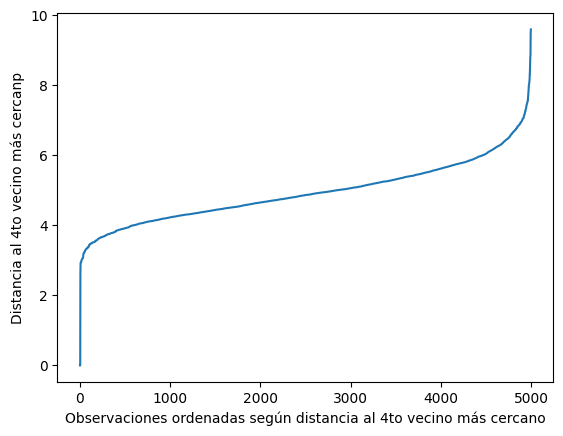

In [31]:
# Uso KNN para encontrar el mejor eps:
NN = NearestNeighbors(n_neighbors=4)
nbrs = NN.fit(x_nor)
distances, indices = nbrs.kneighbors(x_nor)
# Ploteo distancias:
distances = np.sort(distances[:,1]) # Ordeno las distancias para encontrar el codo al plotear.
plt.plot(distances)
plt.ylabel('Distancia al 4to vecino más cercanp')
plt.xlabel('Observaciones ordenadas según distancia al 4to vecino más cercano')

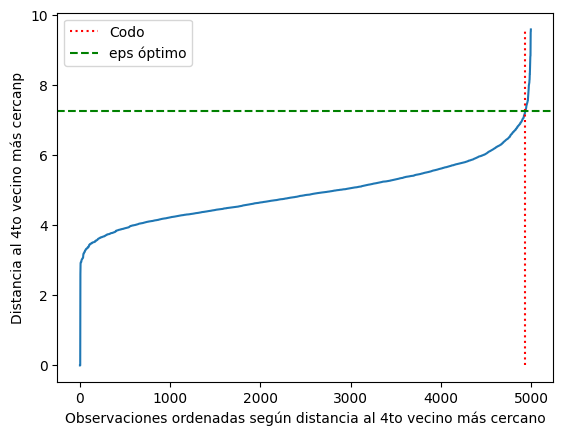

eps óptimo: 7.2576742662091505


In [238]:
# Busco el codo en la curva usando "KneeLocator" de la librería "kneed":
kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
optimal_eps = distances[kneedle.knee]
# Ploteo:
plt.plot(distances)
plt.vlines(x=kneedle.elbow, ymin=min(distances), ymax=max(distances), color='red', linestyle=':', label='Codo')
plt.axhline(y=optimal_eps, color='green', linestyle='--', label='eps óptimo')
plt.legend()
plt.ylabel('Distancia al 4to vecino más cercanp')
plt.xlabel('Observaciones ordenadas según distancia al 4to vecino más cercano')
plt.show()
print("eps óptimo:", optimal_eps)

In [10]:
# kneedle.plot_knee()
# plt.show()

### Selección de *MinPts*

Habiendo determinado en 4 la cantidad de vecinos a considerar para el cálculo del mejor valor de *eps*, tomamos *MinPts* = 4 para generar nuestros clusters.


In [153]:
min_samples = 4

### Aplicamos algoritmo DBSCAN a nuestro dataset

In [154]:
# Usamos features normalizados:
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples).fit(x_nor)
# Chequeo labels:
# labels = dbscan.labels_
labels = dbscan.fit_predict(x_nor)
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

#### **Validación interna**: 

Utilizaremos el coeficiente promedio de Silhouette para evaluar la calidad de los clulsters obtenidos.

In [35]:
# Cantidad de clusters en "labels", ignorando puntos ruido:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Número estimado de clusters: %d" % n_clusters_)
print("Número estimado de puntos ruido: %d" % n_noise_, "\n")
# Silhouette Score
silhouette_avg = silhouette_score(x_nor, labels)
print("Silhouette promedio: ", silhouette_avg)

Número estimado de clusters: 1
Número estimado de puntos ruido: 68 

Silhouette promedio:  0.16844901


Si bien podríamos quedarnos con estos resultados, decidimos hacer una búsqueda más exhaustiva de los hiperparámetros de DBSCAN, basándonos en el coeficiente de Silhouette para ver qué combinación de *eps* y *MinPts* da el mejor resultado. Los rangos a probar para cada parámetro son:
- eps: [5 : 8], step = 0.25
- MinPts: [2 : 10], step = 1 

El fiteo de cada modelo se guarda en la lista "modelos_DBSCAN"

In [115]:
# Guardaremos cada modelo entrenado en una lista de modelos
eps = [i for i in np.arange(5,8.5,0.5)]
min_samples = [i for i in range (2,10,1)]
silhouette_list = []
modelos_DBSCAN = []
results = pd.DataFrame(columns = ["eps","MinPts","Silhouette","n_clusters","n_noise"])

for i in eps:
    for j in min_samples:
        # Aplico el modelo
        dbscan = DBSCAN(eps=i, min_samples=j).fit(x_nor) 
        # Guardo el modelo 
        modelos_DBSCAN.append(dbscan)
        ## Evaluo métricas
        # SSE:
        labels = dbscan.fit_predict(x_nor) 
        # Silhouette Score
        silhouette_avg = silhouette_score(x_nor, labels)
        # Guardo resultados
        new_row = {"eps": i, "MinPts": j, "Silhouette": silhouette_avg, "n_clusters" :len(set(labels)) - (1 if -1 in labels else 0), "n_noise" :list(labels).count(-1)}
        results = pd.concat([results, pd.DataFrame(new_row, index=[0]),], ignore_index=True)
        

In [116]:
results.sort_values(by="Silhouette", ascending=False, inplace=True)
results

,eps,MinPts,Silhouette,n_clusters,n_noise
55,8.0,9,0.207026,1.0,24.0
48,8.0,2,0.207026,1.0,24.0
54,8.0,8,0.207026,1.0,24.0
53,8.0,7,0.207026,1.0,24.0
52,8.0,6,0.207026,1.0,24.0
51,8.0,5,0.207026,1.0,24.0
50,8.0,4,0.207026,1.0,24.0
49,8.0,3,0.207026,1.0,24.0
42,7.5,4,0.182423,1.0,42.0
43,7.5,5,0.181771,1.0,44.0


Ploteo este resultado para ver gráficamente:

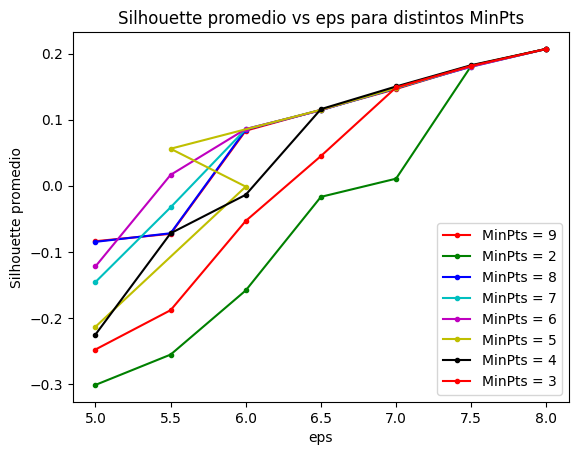

In [92]:
MinPts_values = results['MinPts'].unique()
# Defino colores para las líneas:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

# Una línea para cada MinPts:
for i, minpts in enumerate(MinPts_values):
    eps_minpts = results[results['MinPts'] == minpts]
    color = colors[i % len(colors)]  # Cycle through the color list
    plt.plot(eps_minpts['eps'], eps_minpts['Silhouette'], f'{color}.-', label=f'MinPts = {minpts}')

plt.ylabel('Silhouette promedio')
plt.xlabel('eps')
plt.title('Silhouette promedio vs eps para distintos MinPts')
plt.legend(loc='best')  # Add a legend
plt.show()

**Conclusiones**:

- Del gráfico del coeficiente de Silhouette se puede apreciar que, si bien el mejor caso se alcanza para un *eps* = 8 y cualquier valor de *MinPts* dentro de los evaluados, el coeficiente promedio da muy cercano a cero (o incluso, negativo): ambos casos indicativos de una mala clusterización.

- La tabla de resultados de los modelos evaluados muestra que este algoritmo no es el ideal para nuestro trabajo: tiende a detectar la gran mayoría de los puntos como un único cluster, y los que quedan fuera los cataloga como ruido; el valor del ruido aumenta a medida que se reduce el *eps*, y solo se comienza a detectar más de un único cluster para valores del coeficiente promedio de Silhouette muy cercanos a 0.

Sin embargo, a modo ilustrativo se mostrará el resultado de técnicas de validación externa para el caso de 5 clusters, ya que éste último coincidiría con la cantidad real de etiquetas de nuestro dataset.

#### **Validación externa**:

Evaluaremos ahora las mismas métricas de validación que las utilizadas con K-Means para medir la performance del algoritmo DBSCAN:

- Matríz de Confusión

- Índice de Rand ajustado

- Índice de VanDogen

In [124]:
# Los parámetros de DBSCAN que dieron 5 clusters están en el modelo 17 (índice 17 de df "results"):
n_clusters = 5
modelo_5_clusters = modelos_DBSCAN[17]
mc = validacion_externa(names, modelo_5_clusters)
mc

Índice de Rand Ajustado: 0.005946583825040087
Índice de van Dongen: 0.6721876375275055


Labels_orig,Arborio,Ipsala,Jasmine,Karacadag,basmati
Labels_clust,,,,,
-1,120,238,106,50,52
0,880,746,894,950,948
1,0,6,0,0,0
2,0,3,0,0,0
3,0,4,0,0,0
4,0,3,0,0,0


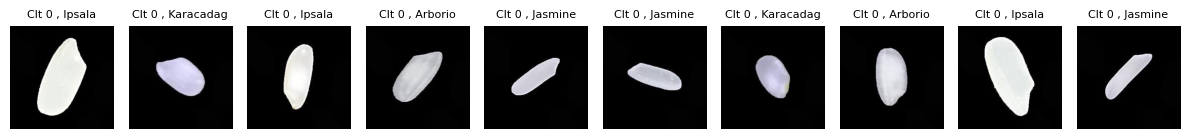

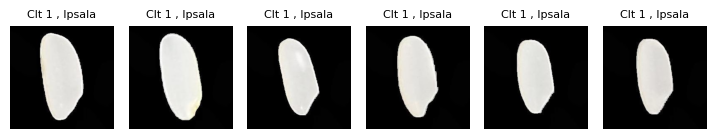

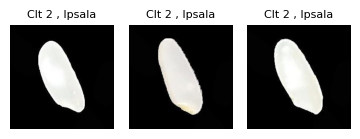

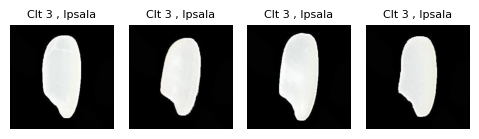

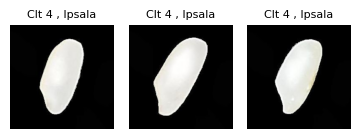

In [123]:
# Observación de etiquetas reales con predichas
for cluster_label in range(n_clusters):
    save_cluster_examples(cluster_label, modelo_5_clusters, names, num_examples=10)

**Conclusiones**:

- El índice de Rand Ajustado da 0.0059, y siendo un valor muy próximo a cero, nos indica que no hay una buena coindencia entre lo obtenido por el modelo y las etiquetas reales. 

- EL Índice de van Dongen, por su parte, nos da 0.67, un valor considerablemente elevado y que refuerza la poca certezada en los clusters obtenidos respecto de la realidad. 

- La matríz de confusión y la figura evidencian que el algoritmo no es capaz de detectar correctamente los distintos tipos de grano: solo el cluster 0 posee al menos 10 elementos, lo cual ya es un indicador de la performance, y se aprecia que se confunde el tipo "Ipsala" en clusters separados y muy pequeños.

### PCA

Ahora aplicaremos el modelo de DBSCAN a nuestros datos reducidos usando PCA, tal y como se hizo con el algoritmo de K-Means. <br>
Se intentó utilizar el par de parámetros de *eps* y *MinPts* que identificó 5 clusters previamente, es decir, *eps* = 6 y *MinPts* = 3, pero dicho resultado arrojó un único gran cluster al aplicarlo sobre los datos reducidos; por este motivo, se modificaron ambos parámetros a mano hasta lograr que el modelo encuentre 5 clusters. A continuación, los resultados:

In [217]:
# A mano, encontré que los mejores parámetros para llegar a 5 clusters son eps = 3.43 y MinPts = 3.
DBSCAN_PCA = DBSCAN(eps=3.43, min_samples=3).fit(x_pca)
# Chequeo labels:
labels = DBSCAN_PCA.fit_predict(x_pca)

# Cantidad de clusters en "labels", ignorando puntos ruido:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Número estimado de clusters: %d" % n_clusters_)
print("Número estimado de puntos ruido: %d" % n_noise_, "\n")
# Silhouette Score
silhouette_avg = silhouette_score(x_pca, labels)
print("Silhouette promedio: ", silhouette_avg)

Número estimado de clusters: 5
Número estimado de puntos ruido: 386 

Silhouette promedio:  -0.080505714


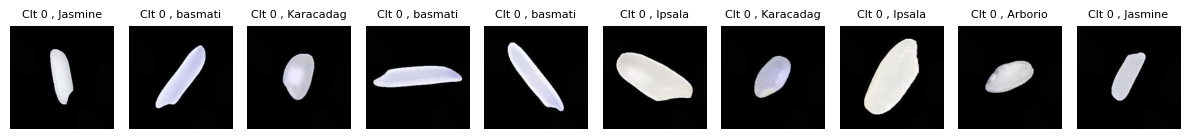

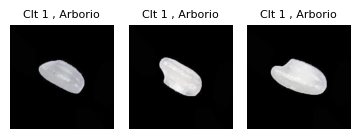

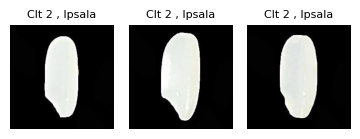

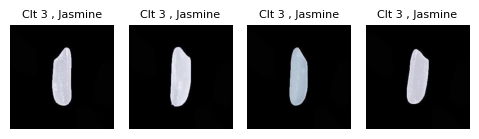

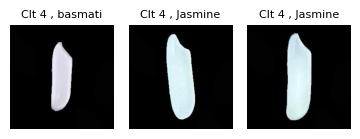

In [218]:
n_clusters = 5
# Observo los clusters obtenidos
for cluster_label in range(n_clusters):
    save_cluster_examples(cluster_label, DBSCAN_PCA, names, num_examples=10)

Si bien no puede decirse que la clusterización haya sido efectiva, al menos se aprecia que los clusters 1, 2 y 3, de pocos elementos, pudieron identificar tipos distintos de arroz sin errores, lo cual representa una mejora respecto de lo que había ocurrido al utilizar los datos sin reducir. 

In [219]:
# Validación externa:
n_clusters = 5
modelo = DBSCAN_PCA
mc = validacion_externa(names, modelo)
mc

Índice de Rand Ajustado: 0.0033246981689573044
Índice de van Dongen: 0.709366673334667


Labels_orig,Arborio,Ipsala,Jasmine,Karacadag,basmati
Labels_clust,,,,,
-1,129,141,87,15,14
0,868,856,907,985,985
1,3,0,0,0,0
2,0,3,0,0,0
3,0,0,4,0,0
4,0,0,2,0,1


Como era de esperarse, ninguno de los índices ha mejorado: ambos reflejan una clusterización poco efectiva respecto de las clases originales.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


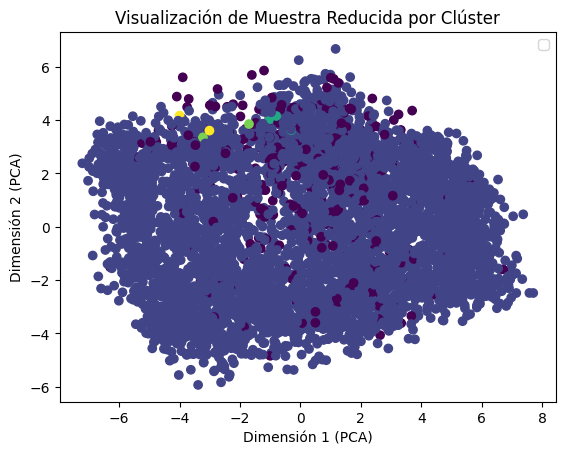

In [220]:
# Grafiquemos en un espacio bidimensional las PC1 y PC2
plt.scatter(x_pca[:, 0], x_pca[:, 1],c=DBSCAN_PCA.labels_)
    
# Agrega una leyenda al gráfico
plt.legend()

# Personaliza los títulos y etiquetas de los ejes
plt.title('Visualización de Muestra Reducida por Clúster')
plt.xlabel('Dimensión 1 (PCA)')
plt.ylabel('Dimensión 2 (PCA)')

# Muestra el gráfico
plt.show()

Este gráfico confirma lo que los números predecían: una gran nube de muchos puntos superpuestos, indistinguibles entre sí, y pequeños intentos por clusterizar muestras que deberían ser parte de un cluster mayor.

## 6.c PAM (Partition Around Medoids)

Finalmente, probaremos el rendimiento del método del método de clustering *PAM (Partition Aroud Medoids)*, o también conocido como *K-medoids* para evaluar sus diferencias de performance respecto de lo ya realizado para el modelo de K-Means, que opera de ofrma similar.<br>
Al igual que K-means, PAM se basa en la preselección de la **cantidad de clústers a identificar**.

Para que la comparación tenga sentido, mantenemos la normalización mediante el escalador de mínimo y máximo hecha previamente.

### **Modelo**: 
Implementaremos el modelo PAM variando la cantidad de clusters y con el objetivo de encontrar cantidad de clusters óptimo. 

Utilizaremos la librerías de pyclustering.

https://pyclustering.github.io/docs/0.9.0/html/d0/dd3/classpyclustering_1_1cluster_1_1kmedoids_1_1kmedoids.html

#### **Validación interna**: 

Utilizaremos las siguientes medidas para evaluar la calidad de los clusters obtenidos en cada implementación. Estas  nos permitirán medir la coherencia y la separación de los mismos. 

SSE: Mide la dispersión de las observaciones dentro de cada cluster, cuanto menor sea el SSE, más compactos y coherentes serán los clusters. 

Silhouette Score: Mide cuán similar es cada punto de datos a su propio cluster comparándolo con otros clusters cercanos. Este score varía entre -1 y 1 y mientras más cerano a 1 indicará que el punto está bien agrupado, cuanto más cercano a cero o negativo sea, indicará que está en el cluster incorrecto.


## PAM con sklearn

In [324]:
kmedoids = KMedoids(n_clusters=5, random_state=8).fit(x_nor)
kmedoids.labels_
kmedoids.predict(x_nor)


array([3, 4, 4, ..., 0, 0, 0], dtype=int64)

In [335]:
kmedoids = KMedoids(n_clusters=2,  random_state = 8)
kmedoids

KMeans(n_clusters=2, random_state=8)

In [338]:
# Veamos para una serie de valores de n_clusters cómo se comportan las métricas expuestas:
# Guardaremos cada modelo entrenado en una lista de modelos
k_range = [i for i in range(2,20)]
sse_list = []
silhouette_list = []
modelos_PAM = []

for i in k_range:
    # Aplico el modelo
    kmedoids = KMedoids(n_clusters=i,  random_state = 8)
    kmedoids.fit(x_nor)
    
    # Guardo el modelo 
    modelos_PAM.append(kmedoids)
    
    # Evaluo métricas
    # SSE:
    labels = kmedoids.predict(x_nor)
    centroides = kmedoids.cluster_centers_
    sse = 0  
    for i in range(len(x_nor)):
        cluster_center = centroides[labels[i]]
        sse += np.sum((x_nor[i] - cluster_center) ** 2)
    # Guardo score
    sse_list.append(sse)
    
    # Silhouette Score
    silhouette_avg = silhouette_score(x_nor, labels)
    # Guardo score
    silhouette_list.append(silhouette_avg)

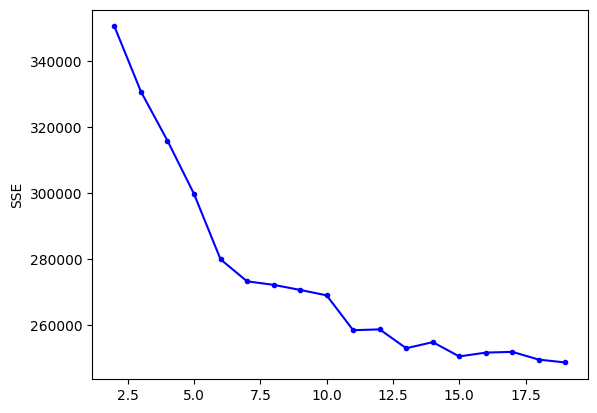

In [339]:
# Graficamos los resultados obtenidos para cada métrica
# SSE
plt.plot(k_range,sse_list,'b.-')
plt.ylabel('SSE')
plt.show()

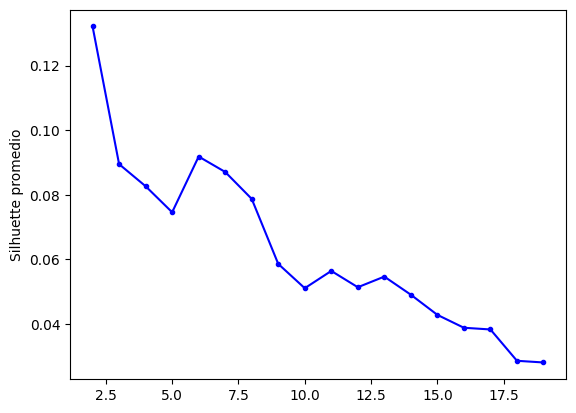

In [340]:
# Silhouette Score
plt.plot(k_range,silhouette_list,'b.-')
plt.ylabel('Silhuette promedio')
plt.show()

**Conclusiones**:

- Similar a lo que ocurre con K-means, del gráfico del SSE podemos notar que el valor de la métrica disminuye mientras aumenta la cantidad de clusters de una forma suave, sin presentar un quiebre que indique de forma obvia la cantidad de clusters óptimo. Esto quizas se deba a que nuestros datos no poseen una estructura de clusters clara.

- Del gráfico del Score de Silhouette podemos notar que para todos los valores de n_clusters seleccionados el valor de silhouette es cercano a cero por lo que no podríamos tomar con certeza una cantidad válida de clusters.

Para ser consistentes con el resto del trabajo, mostraremos visualmente cómo el modelo agrupa las imagenes tomando 5 clusters (labels originales) y 7 clusters.

### Validación externa:

Evaluaremos para los n_clusters seleccionados cómo varía respecto a las etiques originales de las imagenes, para esto, utilizaremos las siguientes técnicas de validación:

- Matríz de Confusión

- Índice de Rand ajustado : puede proporcionar un valor entre -1 y 1, donde 1 indica una concordancia perfecta entre las asignaciones de clústeres y 0 indica una asignación aleatoria. Un valor negativo indica una asignación menos acertada que una asignación aleatoria.

- Índice de VanDogen : Es una métrica de disimilaridad entre particiones basada también en la intersección máxima de clusters. Vale cero cuando las particiones son iguales.

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.colibri.udelar.edu.uy/jspui/bitstream/20.500.12008/21101/1/tm-mgonzalez.pdf 


In [341]:
# Para n_clusters = 5
n_clusters = 5
modelo = modelos_PAM[3]
mc = validacion_externa(names, modelo)
mc

Índice de Rand Ajustado: 0.43571416550610664
Índice de van Dongen: 0.1830878975795159


Labels_orig,Arborio,Ipsala,Jasmine,Karacadag,basmati
Labels_clust,,,,,
0,5,17,387,0,919
1,96,128,441,7,43
2,91,14,0,925,0
3,403,530,36,17,3
4,405,311,136,51,35


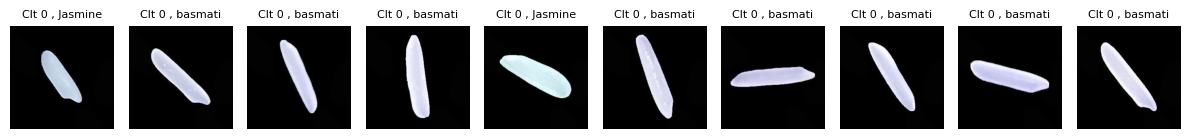

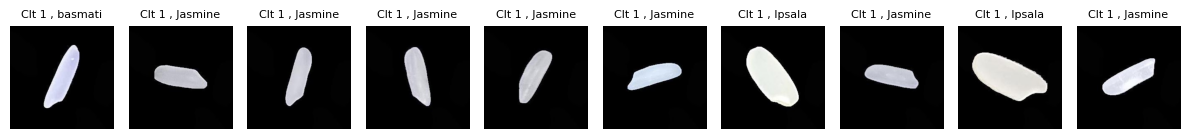

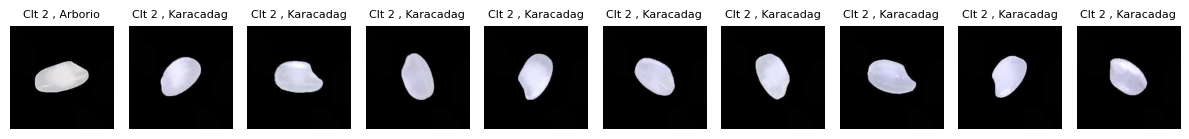

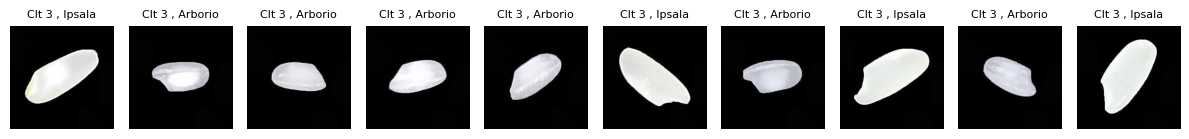

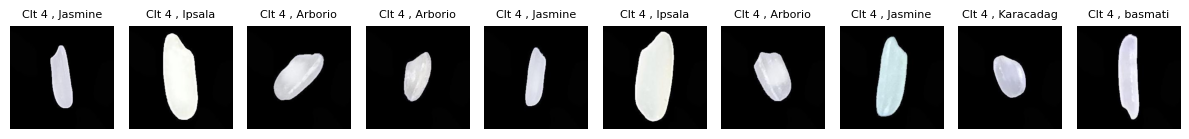

In [342]:
# Observación de etiquetas reales con predichas
for cluster_label in range(n_clusters):
    save_cluster_examples(cluster_label, modelo, names, num_examples=10)

**Conclusiones**:

- El índice de Rand Ajustado da 0.44 (ligeramente superior a k-means) lo cual nos indica que, si bien la agrupación no es destacable, no es un valor tan bajo. 

- EL Índice de van Dongen por su parte nos da 0.18 (ídem k-means), lo cual también indica que hay cierta certezada en los clusters obtenido respecto a lo real. 

- La matríz de confusión y la figura evidencian que ninguna clase fue clasificada de forma perfecta: al igual que k-means, el tipo de arroz Karacadag lo clasifica bastante bien en el clusters 2, lo cual nos permite inferir que su forma redondeada favorece su identificación. Los clusters 0 y 1, si bien presentan confusión entre los tipos de Bssmati y Jasmine, podemos notar que agrupo arroces con forma particularmente alargadas. Los clusters 3 y 4 confunden bastante entre los tipos Arborio e Ipsala que a simple vista parecen ser bastante similares.




In [343]:
# Para n_clusters = 7
n_clusters = 7
modelo = modelos_PAM[5]
mc = validacion_externa(names, modelo)
mc

Índice de Rand Ajustado: 0.4244298741572869
Índice de van Dongen: 0.16744580916183235


Labels_orig,Arborio,Ipsala,Jasmine,Karacadag,basmati
Labels_clust,,,,,
0,0,0,36,0,584
1,12,33,379,0,45
2,68,13,0,891,0
3,264,213,26,7,1
4,378,318,16,50,3
5,3,26,533,0,367
6,275,397,10,52,0


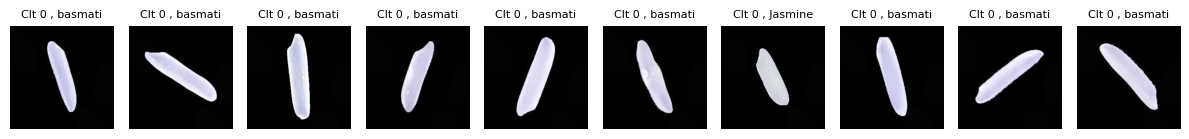

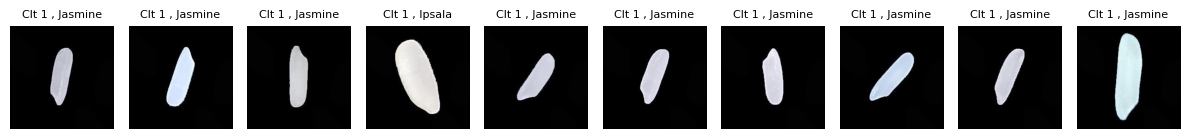

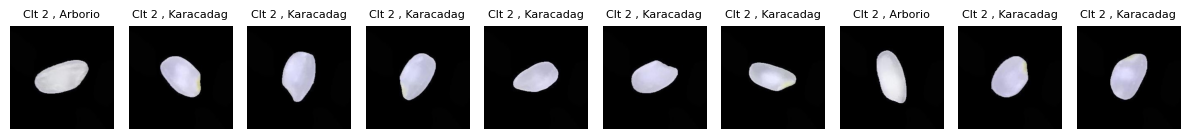

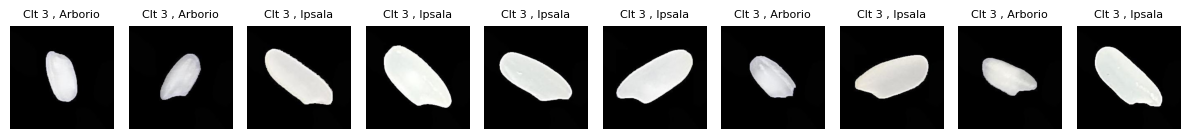

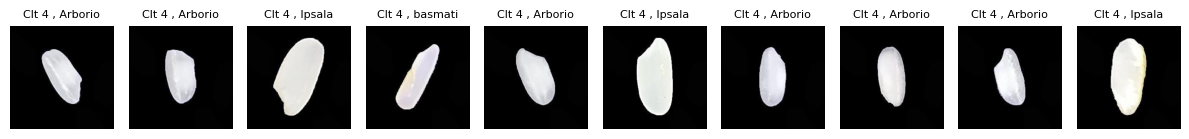

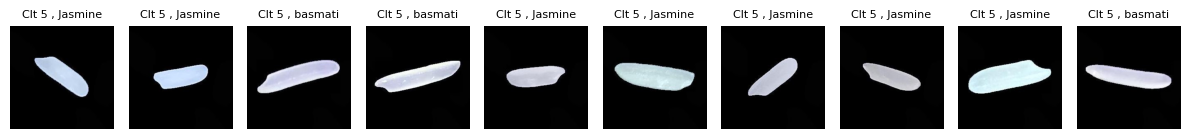

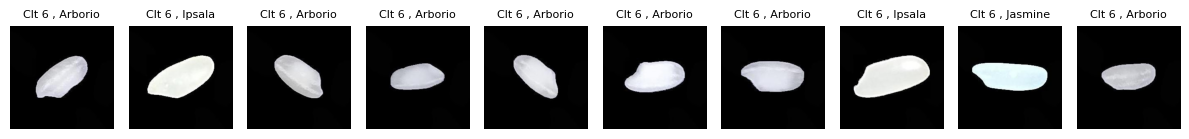

In [344]:
# Observación de etiquetas reales con predichas
for cluster_label in range(n_clusters):
    save_cluster_examples(cluster_label, modelo, names, num_examples=10)

**Conclusiones**:

- El índice de Rand Ajustado da 0.42 lo cual nos indica que no hay una coindencia exacta entre lo obtenido por el modelo y las etiquetas reales. Sin embargo, no es tan cercano a cero. 

- EL Índice de van Dongen por su parte nos da 0.17, algo superior a lo obtenido con K-means, y por ende, evidenciando una ligeramente peor clusterización.

- Ambos índices bajaron respecto a la configuración de 5 clusters, lo cual es bueno para el caso del índice de Van Dongen, pero malo para el índide de Rand ajustado. 

- La matríz de confusión y la figura presentan mayor confusión en la mayoría de los clusters. Sin embargo, podemos destacar los clusters 0,1,4 y 7 que visualmente agrupa los arroces más alargados y más redondeados. 

### PCA

Notemos que podemos representar los datos con dos dimensiones PC1 y PC2 y explicando un 43% de la variabilidad total de los datos. Esto sugiere que la aplicación del PCA ha sido efectiva y nos permitirá visualizar clústeres con datos complejos en un espacio bidimensional.

In [345]:
# Aplicamos ahora Kmeans a los datos reducidos
kmedoids = KMedoids(n_clusters=5,  random_state = 8)
kmedoids.fit(x_pca)

KMedoids(n_clusters=5, random_state=8)

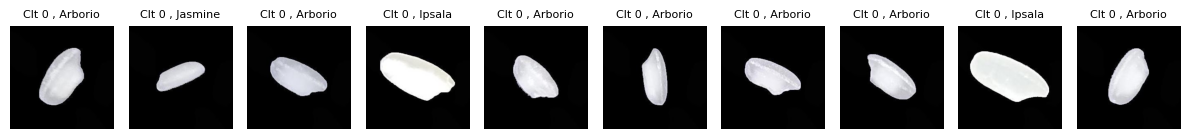

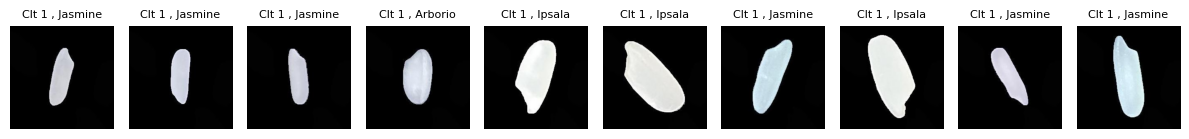

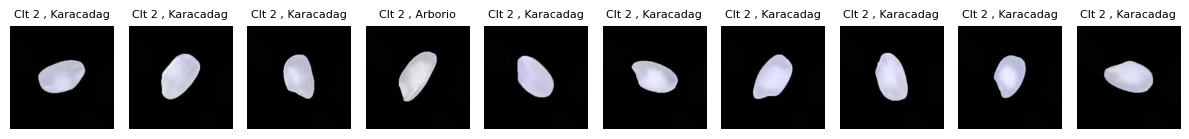

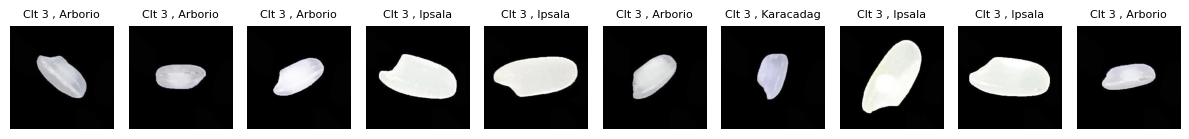

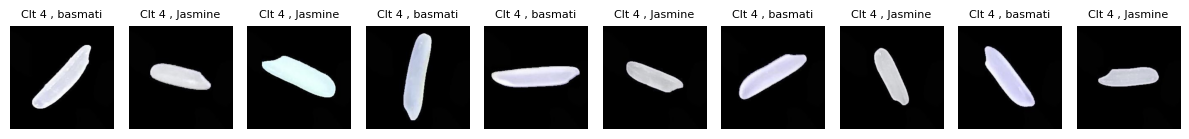

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [346]:
# Observo los clusters obtenidos
for cluster_label in range(n_clusters):
    save_cluster_examples(cluster_label, kmedoids, names, num_examples=10)

In [348]:
# Para n_clusters = 5
n_clusters = 5
modelo = kmedoids
mc = validacion_externa(names, modelo)
mc

Índice de Rand Ajustado: 0.4105807466373701
Índice de van Dongen: 0.192025525105021


Labels_orig,Arborio,Ipsala,Jasmine,Karacadag,basmati
Labels_clust,,,,,
0,348,159,241,14,18
1,282,441,285,41,14
2,63,11,0,889,0
3,306,389,49,56,0
4,1,0,425,0,968


Se puede observar un descenso en el índice de Rand Ajustado el cual nos podría indicar que las nuevas asignaciones de clusters son menos similares usando 50 características respecto a las 4096 características que tomamos anteriormente. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


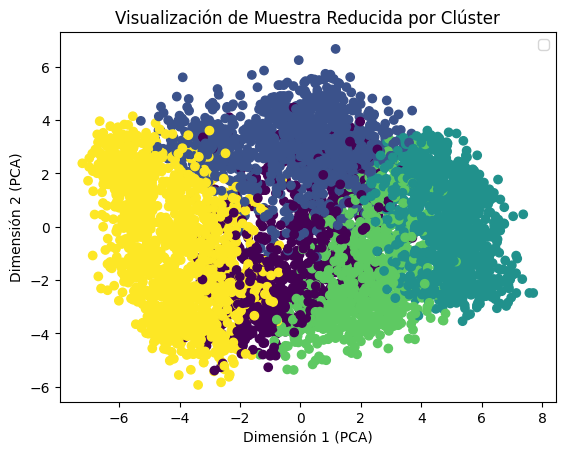

In [349]:
# Grafiquemos en un espacio bidimensional las PC1 y PC2
plt.scatter(x_pca[:, 0], x_pca[:, 1],c=kmedoids.labels_)
    
# Agrega una leyenda al gráfico
plt.legend()

# Personaliza los títulos y etiquetas de los ejes
plt.title('Visualización de Muestra Reducida por Clúster')
plt.xlabel('Dimensión 1 (PCA)')
plt.ylabel('Dimensión 2 (PCA)')

# Muestra el gráfico
plt.show()

Este gráfico nos muestra como ha agrupado en 5 clusters el modelo. Se observan nubes de datos coherentes respecto a las etiquetas del modelo. Veamos ahora respecto a las etiquetas reales:

In [ ]:
labels_original = obtengo_labels_originales(names)
categorias = list(set(labels_original))  # Obtiene las categorías únicas
mapeo_categorias = {categoria: numero for numero, categoria in enumerate(categorias)}

# Mapea las cadenas a números utilizando el diccionario
labels_num = [mapeo_categorias[categoria] for categoria in labels_original]


# Genero dataset con PC1, PC2 y el label_num
dataset = np.column_stack((x_pca[:, 0], x_pca[:, 1], labels_num))

df = pd.DataFrame(data=dataset, columns=['PC1', 'PC2', 'label_num'])

C:\Users\tgian\AppData\Local\Temp\ipykernel_22080\2585690877.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores_unicos = plt.cm.get_cmap('tab10', num_etiquetas)


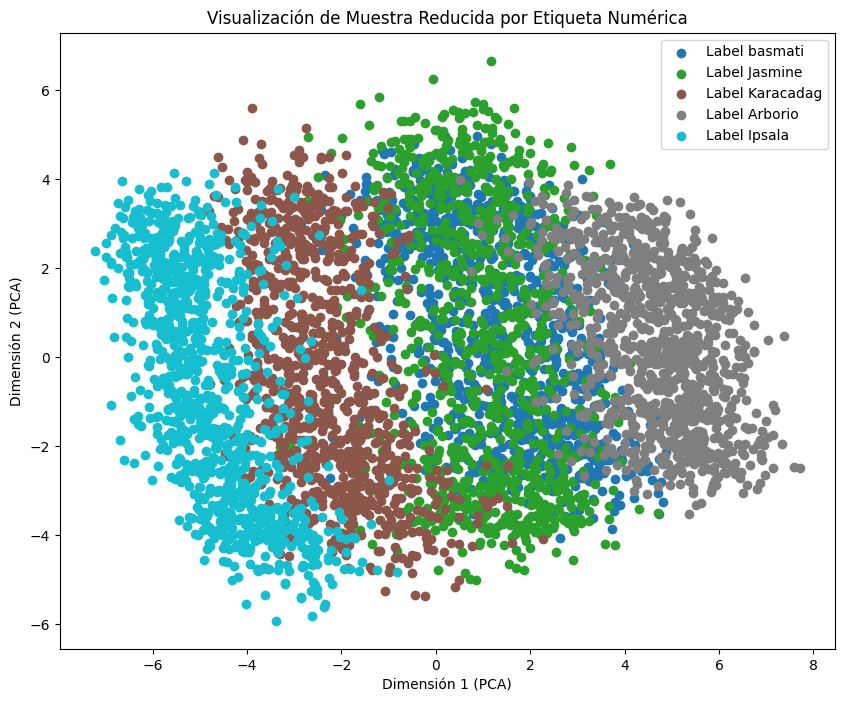

In [ ]:
categorias_dic = {0: 'basmati', 1:'Jasmine', 2:'Karacadag', 3:'Ipsala', 4:'Arborio'}
plt.figure(figsize=(10, 8))

# Obtén el número de etiquetas únicas en 'label_num'
num_etiquetas = len(df['label_num'].unique())

# Genera colores únicos basados en el número de etiquetas
colores_unicos = plt.cm.get_cmap('tab10', num_etiquetas)

# Crear un diccionario para asignar colores únicos a cada etiqueta numérica
mapeo_colores = {etiqueta: colores_unicos(i) for i, etiqueta in enumerate(df['label_num'].unique())}

# Itera a través de las etiquetas únicas presentes en 'label_num'
for etiqueta in df['label_num'].unique():
    # Filtra los puntos de datos correspondientes a esta etiqueta
    x_pca_etiqueta = df[df['label_num'] == etiqueta]
    
    # Obtén el color único para esta etiqueta numérica
    color = mapeo_colores[etiqueta]
    
    # Grafica los puntos de datos de esta etiqueta con el color único
    plt.scatter(x_pca_etiqueta['PC1'], x_pca_etiqueta['PC2'], label=f'Label {categorias_dic[etiqueta]}', color=color)

# Personaliza los títulos y etiquetas de los ejes
plt.title('Visualización de Muestra Reducida por Etiqueta Numérica')
plt.xlabel('Dimensión 1 (PCA)')
plt.ylabel('Dimensión 2 (PCA)')

# Agrega una leyenda al gráfico
plt.legend()

# Muestra el gráfico
plt.show()

**Conclusiones**:

Es posible observar del gráfico en 2 dimensiones que los tipos de arroz mejor agrupados son "Ipsala" y "Arborio". observaciones del tipo de arroz Karacadag a la izquierda del gráfico, y presenta una mezcla bastante pronunciada en el medio entre los tipo Ipsala y Arborio, y a la derecha una mezcla parcial entre Jasmine y Basmati. Además, se corresponde con lo observado en la matriz de confusión.